<a href="https://colab.research.google.com/github/HimashiRathnayake/Pump-it-Up-Data-Mining-the-Water-Table-Competition/blob/main/Final%20Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Dependencies**

In [1]:
# !pip install --upgrade category_encoders

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pandas.api.types import CategoricalDtype
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from category_encoders import MEstimateEncoder
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import StandardScaler
from google.colab import drive

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.6.0
Running on TPU  ['10.111.197.66:8470']
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## **Load Data**

In [5]:
folder_path = "/content/drive/Shareddrives/Other/MLProject/"

In [6]:
train_data = pd.read_csv(folder_path + "TrainingSetValues.csv")
train_labels  = pd.read_csv(folder_path + "TrainingSetLabels.csv")
test_data = pd.read_csv(folder_path + "TestSetValues.csv")

In [7]:
train_data = train_data.set_index("id")
test_data = test_data.set_index("id")
train_labels = train_labels.set_index("id")

all_data = pd.concat([train_data, test_data])

## **Analyse Dataset**

#### **Dataset Information**

**Train Data**

In [8]:
train_data[:5]

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


**Train Labels**

In [9]:
train_labels[:5]

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


**Dataset Information**

In [10]:
display(all_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 69572 to 68707
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             74250 non-null  float64
 1   date_recorded          74250 non-null  object 
 2   funder                 69746 non-null  object 
 3   gps_height             74250 non-null  int64  
 4   installer              69718 non-null  object 
 5   longitude              74250 non-null  float64
 6   latitude               74250 non-null  float64
 7   wpt_name               74250 non-null  object 
 8   num_private            74250 non-null  int64  
 9   basin                  74250 non-null  object 
 10  subvillage             73780 non-null  object 
 11  region                 74250 non-null  object 
 12  region_code            74250 non-null  int64  
 13  district_code          74250 non-null  int64  
 14  lga                    74250 non-null  object 
 15

None

In [144]:
train_labels.value_counts(normalize=True)

status_group
0               0.543081
2               0.384242
1               0.072677
dtype: float64

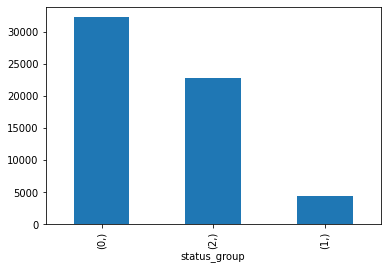

In [142]:
train_labels.value_counts().plot(kind="bar")

We can see a imbalanced problem in the dataset as we have very few `functional needs repair` data. So we need to consider this when we apply the model to the dataset.

#### **Get Unique Values in Each Feature**

In [12]:
# # print('id', all_data.id.unique())
# print('\namount_tsh', all_data.amount_tsh.unique())
# print('\ndate_recorded', all_data.date_recorded.unique())
# print('\nfunder', all_data.funder.unique())
# print('\ngps_height', all_data.gps_height.unique())
# print('\ninstaller', all_data.installer.unique())
# print('\nlongitude', all_data.longitude.unique())
# print('\nlatitude', all_data.latitude.unique())
# print('\nwpt_name', all_data.wpt_name.unique())
# print('\nnum_private', all_data.num_private.unique())
# print('\nbasin', all_data.basin.unique())
# print('\nsubvillage', all_data.subvillage.unique())
# print('\nregion', all_data.region.unique())
# print('\nregion_code', all_data.region_code.unique())
# print('\ndistrict_code', all_data.district_code.unique())
# print('\nlga', all_data.lga.unique())
# print('\nward', all_data.ward.unique())
# print('\npopulation', all_data.population.unique())
# print('\npublic_meeting', all_data.public_meeting.unique())
# print('\nrecorded_by', all_data.recorded_by.unique())
# print('\nscheme_name', all_data.scheme_name.unique())
# print('\npermit', all_data.permit.unique())
# print('\nconstruction_year', all_data.construction_year.unique())
print('\nextraction_type', all_data.extraction_type.unique())
print('extraction_type_group', all_data.extraction_type_group.unique())
print('extraction_type_class', all_data.extraction_type_class.unique())
print('\nscheme_management', all_data.scheme_management.unique())
print('management', all_data.management.unique())
print('management_group', all_data.management_group.unique())
print('\npayment:', all_data.payment.unique())
print('payment_type:', all_data.payment_type.unique())
print('\nwater_quality', all_data.water_quality.unique())
print('quality_group', all_data.quality_group.unique())
print('\nquantity:', all_data.quantity.unique())
print('quantity_group:', all_data.quantity_group.unique())
print('\nsource', all_data.source.unique())
print('source_type', all_data.source_type.unique())
print('source_class', all_data.source_class.unique())
print('\nwaterpoint_type', all_data.waterpoint_type.unique())
print('waterpoint_type_group', all_data.waterpoint_type_group.unique())


extraction_type ['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'ksb' 'mono' 'windmill' 'afridev' 'other - rope pump' 'india mark iii'
 'other - swn 81' 'other - play pump' 'cemo' 'climax' 'walimi'
 'other - mkulima/shinyanga']
extraction_type_group ['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'mono' 'wind-powered' 'afridev' 'rope pump' 'india mark iii'
 'other handpump' 'other motorpump']
extraction_type_class ['gravity' 'submersible' 'handpump' 'other' 'motorpump' 'wind-powered'
 'rope pump']

scheme_management ['VWC' 'Other' nan 'Private operator' 'WUG' 'Water Board' 'WUA'
 'Water authority' 'Company' 'Parastatal' 'Trust' 'SWC' 'None']
management ['vwc' 'wug' 'other' 'private operator' 'water board' 'wua' 'company'
 'water authority' 'parastatal' 'unknown' 'other - school' 'trust']
management_group ['user-group' 'other' 'commercial' 'parastatal' 'unknown']

payment: ['pay annually' 'never pay' 'pay per bucket' 'unknown'
 'pay whe

#### **Check value counts in similar type features**

###### **Scheme_management, Management & Management_group**

In [13]:
print(all_data.scheme_management.value_counts())
print("NaN value count:", all_data.scheme_management.isna().sum())

VWC                 45917
WUG                  6496
Water authority      3975
WUA                  3551
Water Board          3462
Parastatal           2124
Company              1341
Private operator     1326
Other                 996
SWC                   123
Trust                  92
None                    1
Name: scheme_management, dtype: int64
NaN value count: 4846


In [14]:
all_data.management.value_counts()

vwc                 50624
wug                  8108
water board          3688
wua                  3118
private operator     2504
parastatal           2229
water authority      1123
other                1083
company               859
unknown               683
other - school        126
trust                 105
Name: management, dtype: int64

Both scheme_management & management features seems to have same kind of details, so we can drop one of these features. As the scheme_management have some NaN values we decided to drop that feature.

In [15]:
print(all_data.groupby(['management','management_group']).count())

                                   amount_tsh  ...  waterpoint_type_group
management       management_group              ...                       
company          commercial               859  ...                    859
other            other                   1083  ...                   1083
other - school   other                    126  ...                    126
parastatal       parastatal              2229  ...                   2229
private operator commercial              2504  ...                   2504
trust            commercial               105  ...                    105
unknown          unknown                  683  ...                    683
vwc              user-group             50624  ...                  50624
water authority  commercial              1123  ...                   1123
water board      user-group              3688  ...                   3688
wua              user-group              3118  ...                   3118
wug              user-group           

According to above output, we can see management_group is just a grouped version of the management so we can drop management_group which has less details.

###### **Payment & Payment_type**

In [16]:
all_data.payment.value_counts()

never pay                31712
pay per bucket           11266
pay monthly              10397
unknown                  10149
pay when scheme fails     4842
pay annually              4570
other                     1314
Name: payment, dtype: int64

In [17]:
all_data.payment_type.value_counts()

never pay     31712
per bucket    11266
monthly       10397
unknown       10149
on failure     4842
annually       4570
other          1314
Name: payment_type, dtype: int64

In [18]:
print(all_data.groupby(['payment','payment_type']).count())

                                    amount_tsh  ...  waterpoint_type_group
payment               payment_type              ...                       
never pay             never pay          31712  ...                  31712
other                 other               1314  ...                   1314
pay annually          annually            4570  ...                   4570
pay monthly           monthly            10397  ...                  10397
pay per bucket        per bucket         11266  ...                  11266
pay when scheme fails on failure          4842  ...                   4842
unknown               unknown            10149  ...                  10149

[7 rows x 37 columns]


Both payment and payment_type have same values so we can drop one of them.

###### **Water_quality & Quality_group**

In [19]:
all_data.water_quality.value_counts()

soft                  63505
salty                  6082
unknown                2345
milky                  1005
coloured                623
salty abandoned         423
fluoride                244
fluoride abandoned       23
Name: water_quality, dtype: int64

In [20]:
all_data.quality_group.value_counts()

good        63505
salty        6505
unknown      2345
milky        1005
colored       623
fluoride      267
Name: quality_group, dtype: int64

In [21]:
print(all_data.groupby(['water_quality','quality_group']).count())

                                  amount_tsh  ...  waterpoint_type_group
water_quality      quality_group              ...                       
coloured           colored               623  ...                    623
fluoride           fluoride              244  ...                    244
fluoride abandoned fluoride               23  ...                     23
milky              milky                1005  ...                   1005
salty              salty                6082  ...                   6082
salty abandoned    salty                 423  ...                    423
soft               good                63505  ...                  63505
unknown            unknown              2345  ...                   2345

[8 rows x 37 columns]


*Both water_quality & quality_group seem to be similar but since water_quality has more details (fluoride and salty in quality_group devided into some more classes in water_quality) we can drop quality_group.*

###### **Quantity vs Quantity_group**

In [22]:
all_data.quantity.value_counts()

enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: quantity, dtype: int64

In [23]:
all_data.quantity_group.value_counts()

enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: quantity_group, dtype: int64

In [24]:
print(all_data.groupby(['quantity','quantity_group']).count())

                             amount_tsh  ...  waterpoint_type_group
quantity     quantity_group              ...                       
dry          dry                   7782  ...                   7782
enough       enough               41522  ...                  41522
insufficient insufficient         18896  ...                  18896
seasonal     seasonal              5075  ...                   5075
unknown      unknown                975  ...                    975

[5 rows x 37 columns]


*Both qunatity and quantity_group have same values so we can drop one of them.*

###### **Waterpoint_type vs Water Type Group**

In [25]:
all_data.waterpoint_type.value_counts()

communal standpipe             35628
hand pump                      21884
other                           8010
communal standpipe multiple     7611
improved spring                  959
cattle trough                    150
dam                                8
Name: waterpoint_type, dtype: int64

In [26]:
all_data.waterpoint_type_group.value_counts()

communal standpipe    43239
hand pump             21884
other                  8010
improved spring         959
cattle trough           150
dam                       8
Name: waterpoint_type_group, dtype: int64

In [27]:
print(all_data.groupby(['waterpoint_type','waterpoint_type_group']).count())

                                                   amount_tsh  ...  source_class
waterpoint_type             waterpoint_type_group              ...              
cattle trough               cattle trough                 150  ...           150
communal standpipe          communal standpipe          35628  ...         35628
communal standpipe multiple communal standpipe           7611  ...          7611
dam                         dam                             8  ...             8
hand pump                   hand pump                   21884  ...         21884
improved spring             improved spring               959  ...           959
other                       other                        8010  ...          8010

[7 rows x 37 columns]


*Both waterpoint_type & waterpoint_type_group seems to have similar values. As waterpoint_type has more details we can drop other one.*

###### **Extraction_type, extraction_type_group & extraction_type_class**

In [28]:
all_data.extraction_type.value_counts()

gravity                      33263
nira/tanira                  10205
other                         8102
submersible                   5982
swn 80                        4588
mono                          3628
india mark ii                 3029
afridev                       2208
ksb                           1790
other - rope pump              572
other - swn 81                 284
windmill                       152
india mark iii                 135
cemo                           108
other - play pump              101
walimi                          60
climax                          41
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [29]:
all_data.extraction_type_group.value_counts()

gravity            33263
nira/tanira        10205
other               8102
submersible         7772
swn 80              4588
mono                3628
india mark ii       3029
afridev             2208
rope pump            572
other handpump       447
wind-powered         152
other motorpump      149
india mark iii       135
Name: extraction_type_group, dtype: int64

In [30]:
print(all_data.groupby(['extraction_type','extraction_type_group']).count())

                                                 amount_tsh  ...  waterpoint_type_group
extraction_type           extraction_type_group              ...                       
afridev                   afridev                      2208  ...                   2208
cemo                      other motorpump               108  ...                    108
climax                    other motorpump                41  ...                     41
gravity                   gravity                     33263  ...                  33263
india mark ii             india mark ii                3029  ...                   3029
india mark iii            india mark iii                135  ...                    135
ksb                       submersible                  1790  ...                   1790
mono                      mono                         3628  ...                   3628
nira/tanira               nira/tanira                 10205  ...                  10205
other                     other 

Both extraction_type & extraction_type_group seems to have same details but in `extraction_type` some classes have very low values compared to the total number of data. So we can drop the `extraction_type`.

In [31]:
all_data.extraction_type_class.value_counts()

gravity         33263
handpump        20612
other            8102
submersible      7772
motorpump        3777
rope pump         572
wind-powered      152
Name: extraction_type_class, dtype: int64

In [32]:
print(all_data.groupby(['extraction_type_group', 'extraction_type_class']).count())

                                             amount_tsh  ...  waterpoint_type_group
extraction_type_group extraction_type_class              ...                       
afridev               handpump                     2208  ...                   2208
gravity               gravity                     33263  ...                  33263
india mark ii         handpump                     3029  ...                   3029
india mark iii        handpump                      135  ...                    135
mono                  motorpump                    3628  ...                   3628
nira/tanira           handpump                    10205  ...                  10205
other                 other                        8102  ...                   8102
other handpump        handpump                      447  ...                    447
other motorpump       motorpump                     149  ...                    149
rope pump             rope pump                     572  ...                

Both `extraction_type_group` & `extraction_type_class` seems to have same details but since `extraction_type_class` have less details we can drop that one.

###### **Source, Source_type & Source_class columns**

In [33]:
all_data.source.value_counts()

spring                  21216
shallow well            21140
machine dbh             13822
river                   11964
rainwater harvesting     2863
hand dtw                 1108
lake                      950
dam                       840
other                     261
unknown                    86
Name: source, dtype: int64

In [34]:
all_data.source_type.value_counts()

spring                  21216
shallow well            21140
borehole                14930
river/lake              12914
rainwater harvesting     2863
dam                       840
other                     347
Name: source_type, dtype: int64

In [35]:
all_data.source_class.value_counts()

groundwater    57286
surface        16617
unknown          347
Name: source_class, dtype: int64

In [36]:
print(all_data.groupby(['source','source_type', 'source_class']).count())

                                                        amount_tsh  ...  waterpoint_type_group
source               source_type          source_class              ...                       
dam                  dam                  surface              840  ...                    840
hand dtw             borehole             groundwater         1108  ...                   1108
lake                 river/lake           surface              950  ...                    950
machine dbh          borehole             groundwater        13822  ...                  13822
other                other                unknown              261  ...                    261
rainwater harvesting rainwater harvesting surface             2863  ...                   2863
river                river/lake           surface            11964  ...                  11964
shallow well         shallow well         groundwater        21140  ...                  21140
spring               spring               groundwa

All three features seems to have the same details. We can drop `source_type`, `source_class` as they have less details and keep `source` feature only.

#### **Plot Figures**

In [37]:
Xy = pd.merge(train_labels, train_data, how = 'inner', left_index = True, right_index=True) # merging train_labels to train_data

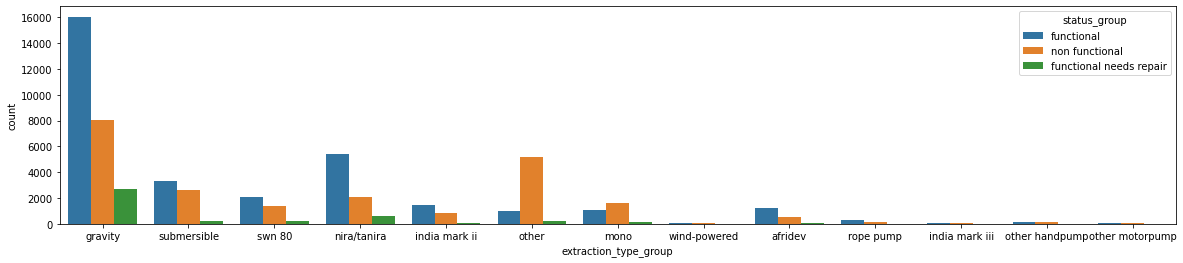

In [38]:
plt.figure(1, figsize=(20,4))
sns.countplot(x='extraction_type_group', hue="status_group", data=Xy)

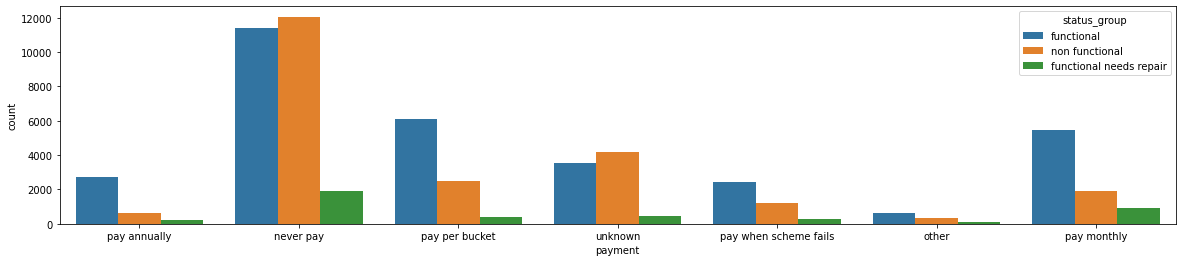

In [39]:
plt.figure(1, figsize=(20,4))
sns.countplot(x='payment', hue="status_group", data=Xy)

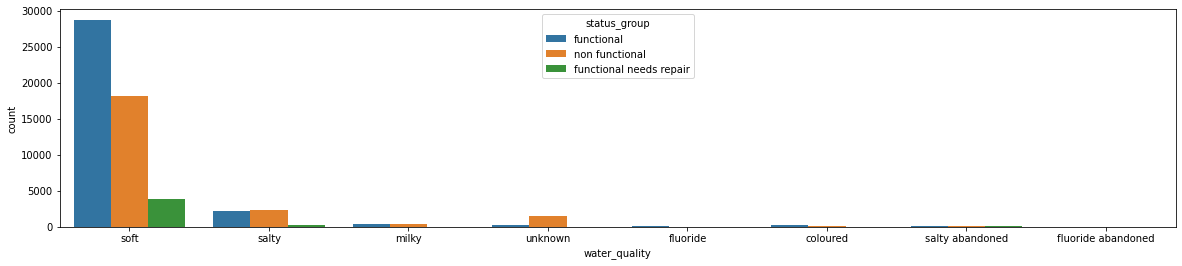

In [40]:
plt.figure(1, figsize=(20,4))
sns.countplot(x='water_quality', hue="status_group", data=Xy)

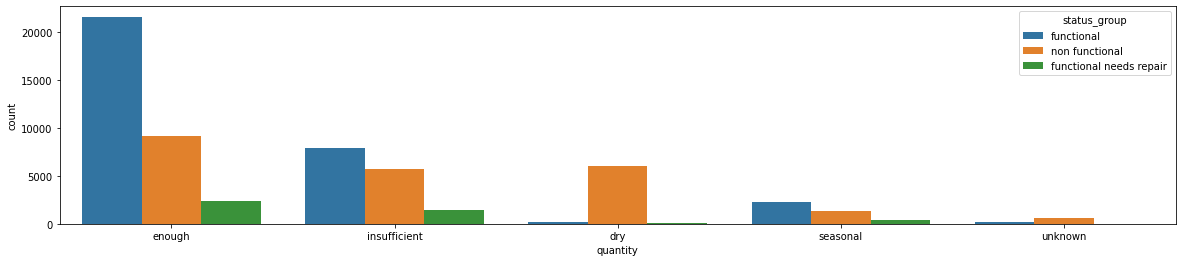

In [41]:
plt.figure(1, figsize=(20,4))
sns.countplot(x='quantity', hue="status_group", data=Xy)

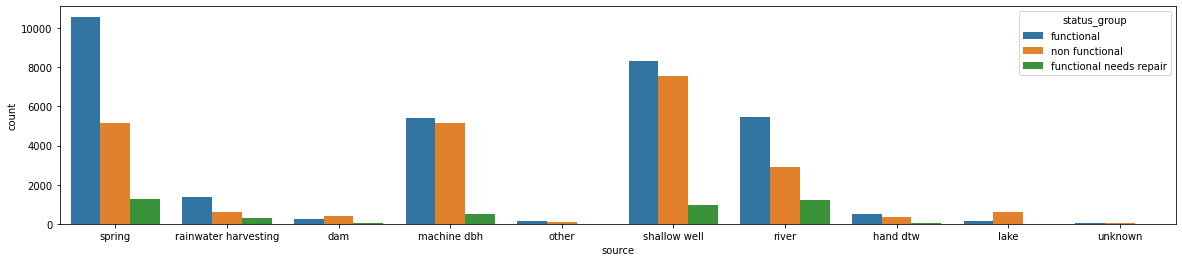

In [42]:
plt.figure(1, figsize=(20,4))
sns.countplot(x='source', hue="status_group", data=Xy)

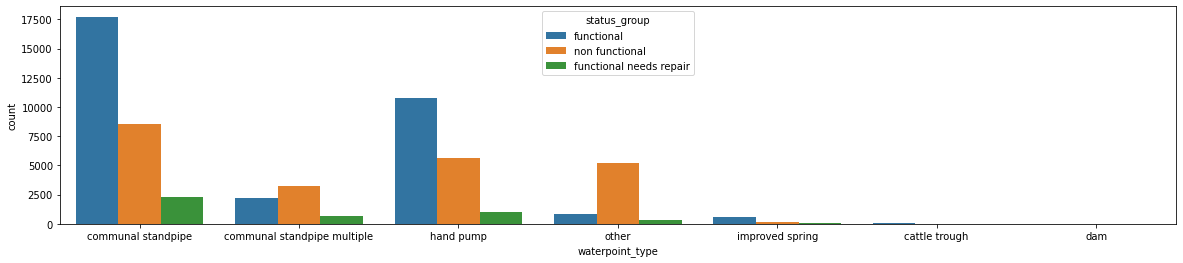

In [43]:
plt.figure(2, figsize=(20,4))
sns.countplot(x='waterpoint_type', hue="status_group", data=Xy)

## **Summary:**

The numeric features : 
* amount_tsh
* gps_height
* longitude
* latitude 
* num_private
* population

Categorical Features :
* date_recoreded, funder, installer, wpt_name, basin, subvillage, region, region_code, district_code, lga, ward, public_meeting, recorded_by, scheme_management, scheme_name, permit, construction_year, extraction_type,extraction_type_group, extraction_type_class, management, management_group, payment, payment_type, water_quality, quality_group, quantity, quantity_group, source, source_type, source_class, waterpoint_type, waterpoint_type_group

Features with Null values: 
* funder, installer, subvillage, public_meeting, scheme_management, scheme_name, permit

**Removed features in preprocessing step**

* source_type - string smalll number of unique values 
* source_class - string smalll number of unique values   
* management_group - string smalll number of unique values
* scheme_management - strings small number of uniques
* quantity_group    string smalll number of unique values
* quality_group - string smalll number of unique values"
* payment_type - string smalll number of unique values
* extraction_type_class - string smalll number of unique values
* extraction_type - string smalll number of unique values
* waterpoint_type_group  string smalll number of unique values

**Removing features in future steps**
* recorded_by - only have obe value for all
* wpt_name - String 45684 unique values
* scheme_name  strings small number of uniques
* region_code -  smalll number of nunique values- numerical data
* num_private  numerical data- have small number of unique values
* Daterecoreded - dates 369 uniques
* subvillage - 21426 unique values strings

## **Data Preprocessing**

#### Clean Data

In [44]:
def fix_typo(df):
    df['installer'].replace(to_replace = ('ADRA /Government') , value ='ADRA/Government' , inplace=True)
    df['installer'].replace(to_replace = ('British colonial government') , value ='British government' , inplace=True)
    df['installer'].replace(to_replace = ('Central Government','Tanzania Government', 'central government','Cental Government', 'Cebtral Government', 'Tanzanian Government','Tanzania government', 'Centra Government', 'CENTRAL GOVERNMENT', 'TANZANIAN GOVERNMENT','Central govt', 'Centr', 'Centra govt') , value ='Central government' , inplace=True)
    df['installer'].replace(to_replace =('Commu','Communit','commu','COMMU', 'COMMUNITY'), value ='Community' , inplace=True)
    df['installer'].replace(to_replace = ('Concern /government') , value ='Concern/Government' , inplace=True)
    df['installer'].replace(to_replace = ('Colonial Government') , value ='Colonial government' , inplace=True)
    df['installer'].replace(to_replace = ('COUN', 'District COUNCIL', 'DISTRICT COUNCIL','District Counci', 'District Council','Council','Counc','District  Council','Distri'), value ='District council' , inplace=True)
    df['installer'].replace(to_replace = ('District Water Department', 'District water depar','Distric Water Department'), value ='District water department' , inplace=True)
    df['installer'].replace(to_replace = 'DANID', value ='DANIDA' , inplace=True)
    df['installer'].replace(to_replace = ('FinW','Fini water','FINI WATER'), value ='Fini Water' , inplace=True)
    df['installer'].replace(to_replace = ('GOVERNMENT', 'GOVER', 'GOVERNME', 'GOVERM','GOVERN','Gover','Gove','Governme','Governmen' ) ,value ='Government' , inplace=True)
    df['installer'].replace(to_replace = ('Government of Misri') , value ='Misri Government' , inplace=True)
    df['installer'].replace(to_replace = ('Government and Community') , value ='Government /Community' , inplace=True)
    df['installer'].replace(to_replace = ('Government /TCRS','Government/TCRS') , value ='TCRS /Government' , inplace=True)    
    df['installer'].replace(to_replace = 'Hesawa', value ='HESAWA' , inplace=True)
    df['installer'].replace(to_replace = ('Italy government') , value ='Italian government' , inplace=True)
    df['installer'].replace(to_replace = 'JAICA', value ='Jaica' , inplace=True)
    df['installer'].replace(to_replace = ('RC CHURCH', 'RC Churc', 'RC','RC Ch','RC C', 'RC CH','RC church', 'RC CATHORIC',) , value ='RC Church' , inplace=True)
    df['installer'].replace(to_replace = ('World vision', 'World Division','World Vision'), value ='world vision' , inplace=True)
    df['installer'].replace(to_replace = ('Unisef','UNICEF'),value ='Unicef' , inplace=True)
    df['installer'].replace(to_replace = ('villigers', 'villager', 'Villagers', 'Villa', 'Village', 'Villi', 'Village Council','Village Counil', 'Villages', 'Vill', 'Village community', 'Villaers', 'Village Community', 'Villag','Villege Council', 'Village council', 'Village  Council','Villagerd', 'Villager', 'Village Technician', 'Village Office','Village community members'), value ='villagers' , inplace=True)
    df['installer'].replace(to_replace = ('Village Government') , value ='Village government' , inplace=True)
    df['installer'].replace(to_replace = ('Cetral government /RC') , value ='RC church/Central Gover' , inplace=True)
    return df

In [45]:
def clean(df):
    # Drop duplicate columns
    df.drop(columns=['source_class','source_type','management_group','scheme_management','quantity_group','quality_group','payment_type','extraction_type_class','extraction_type', 'waterpoint_type_group'],inplace=True)
    df = fix_typo(df)
    return df

#### Encode Data

In [46]:
# The numeric features : amount_tsh, gps_height, longitude, latitude, num_private, population - These numeric features are already encoded correctly

# The categorical features
features_nom = ["date_recorded", "funder", "installer", "wpt_name", "basin", "subvillage", "region", "region_code", "district_code", "lga", "ward", "public_meeting", 
                "recorded_by", "scheme_name", "permit", "construction_year", "extraction_type_group", "management", "payment", "water_quality", "quantity", "source", 
                "waterpoint_type"]

# Add a None level for missing values
ordered_levels = {             
    # list down un ordered categorical coloumn and assign categories
}

def encode(df):   
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories and df[name].isnull().sum() !=0:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels, ordered=True))
    return df

#### Impute Missing Values

In [47]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        if df[name].isnull().sum()!=0:
            df[name] = df[name].fillna("None")
    return df

In [48]:
all_data = clean(all_data) # cleaning dataset
display(all_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 69572 to 68707
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             74250 non-null  float64
 1   date_recorded          74250 non-null  object 
 2   funder                 69746 non-null  object 
 3   gps_height             74250 non-null  int64  
 4   installer              69718 non-null  object 
 5   longitude              74250 non-null  float64
 6   latitude               74250 non-null  float64
 7   wpt_name               74250 non-null  object 
 8   num_private            74250 non-null  int64  
 9   basin                  74250 non-null  object 
 10  subvillage             73780 non-null  object 
 11  region                 74250 non-null  object 
 12  region_code            74250 non-null  int64  
 13  district_code          74250 non-null  int64  
 14  lga                    74250 non-null  object 
 15

None

In [49]:
len(all_data.installer.unique())

2320

In [50]:
all_data = encode(all_data) # encode dataset dtypes
display(all_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 69572 to 68707
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   amount_tsh             74250 non-null  float64 
 1   date_recorded          74250 non-null  category
 2   funder                 69746 non-null  category
 3   gps_height             74250 non-null  int64   
 4   installer              69718 non-null  category
 5   longitude              74250 non-null  float64 
 6   latitude               74250 non-null  float64 
 7   wpt_name               74250 non-null  category
 8   num_private            74250 non-null  int64   
 9   basin                  74250 non-null  category
 10  subvillage             73780 non-null  category
 11  region                 74250 non-null  category
 12  region_code            74250 non-null  category
 13  district_code          74250 non-null  category
 14  lga                    74250 non-n

None

Features with null values: funder, installer, subvillage, public_meeting, scheme_management, scheme_name, permit

In [51]:
all_data = impute(all_data)
print(display(all_data.info()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 69572 to 68707
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   amount_tsh             74250 non-null  float64 
 1   date_recorded          74250 non-null  category
 2   funder                 74250 non-null  category
 3   gps_height             74250 non-null  int64   
 4   installer              74250 non-null  category
 5   longitude              74250 non-null  float64 
 6   latitude               74250 non-null  float64 
 7   wpt_name               74250 non-null  category
 8   num_private            74250 non-null  int64   
 9   basin                  74250 non-null  category
 10  subvillage             74250 non-null  category
 11  region                 74250 non-null  category
 12  region_code            74250 non-null  category
 13  district_code          74250 non-null  category
 14  lga                    74250 non-n

None

None


In [52]:
X_train = all_data.loc[train_data.index, :] # train_data
X_test = all_data.loc[test_data.index, :] # test data
y_train = train_labels # train labels
print(X_train)

       amount_tsh  ...              waterpoint_type
id                 ...                             
69572      6000.0  ...           communal standpipe
8776          0.0  ...           communal standpipe
34310        25.0  ...  communal standpipe multiple
67743         0.0  ...  communal standpipe multiple
19728         0.0  ...           communal standpipe
...           ...  ...                          ...
60739        10.0  ...           communal standpipe
27263      4700.0  ...           communal standpipe
37057         0.0  ...                    hand pump
31282         0.0  ...                    hand pump
26348         0.0  ...                    hand pump

[59400 rows x 29 columns]


### **Remove Features With Less Details**

##### **wpt_name:**

In [53]:
X_train.wpt_name.value_counts().head(100)

none           3563
Shuleni        1748
Zahanati        830
Msikitini       535
Kanisani        323
               ... 
Ringini          22
Vumilia          21
Kwa Richard      21
Jitegemee        21
Galani           21
Name: wpt_name, Length: 100, dtype: int64

wpt_name have 3563 None values, and we can see most of the labels in this feature have very low value count. So we can remove this feature.

##### **scheme_name**

In [54]:
X_train.scheme_name.value_counts().head(100)

None                         28810
K                              682
Borehole                       546
Chalinze wate                  405
M                              400
                             ...  
Manyoni water supply            48
Mwaya Mn                        47
Kazilankanda Water Supply       47
Nyachenda                       47
Gyewasu                         47
Name: scheme_name, Length: 100, dtype: int64

scheme_name have 28810 None values and we can see most of the labels have very low value count. So we can remove this feature.

##### **region_code vs region**

In [55]:
X_train.region_code.value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

In [56]:
X_train.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

As the region and region_code have similar information, we can remove one of them.

##### **amount_tsh:**

In [57]:
X_train.amount_tsh.value_counts()

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

Most of the data 41639/59400 (70%) is 0.0. So we can remove this feature for now.

##### **date_recorded:**

In [58]:
X_train['date_recorded'].value_counts()

2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2011-09-02      0
2011-09-07      0
2011-09-10      0
2011-09-22      0
2001-03-26      0
Name: date_recorded, Length: 369, dtype: int64

We can see most of the dates are beetween 2011-2013. So we can remove this feature as well.

##### **num_private:**

In [59]:
X_train.num_private.value_counts().head(100)

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

Most of the data 58643/59400 (99%) is 0. So we can remove this feature for now.

##### **subvillage:**

In [60]:
X_train.subvillage.value_counts().head(100)

Madukani      508
Shuleni       506
Majengo       502
Kati          373
None          371
             ... 
Tankini        35
Mwangaza       35
Njia Panda     35
Isanga         34
Kiwanjani      34
Name: subvillage, Length: 100, dtype: int64

Most of the labels in `subvillage` have very low value count for most of the label. ALso we can remove this feature.

##### **recorded_by:**

In [61]:
X_train.recorded_by.value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

Since this feature has only one value we cannot get any idea from this feature about the functionality. So we can drop this feature.

##### **Drop identified features**

In [62]:
def drop_fearure_less_columns(df):
    df.drop(columns=['wpt_name', 'scheme_name', 'region_code', 'amount_tsh', 'date_recorded', 'num_private', 'subvillage', 'recorded_by'],inplace=True)
    return df

X_train = drop_fearure_less_columns(X_train)
X_test = drop_fearure_less_columns(X_test)

In [63]:
X_test.columns

Index(['funder', 'gps_height', 'installer', 'longitude', 'latitude', 'basin',
       'region', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'permit', 'construction_year',
       'extraction_type_group', 'management', 'payment', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='object')

### **Reduce Features' Label Count**

Since there are very large number of categories in `installer` feature we will keep only the categories have more than 400 values and rename all other categories to `other` category.

In [64]:
X_train['installer'].replace(to_replace = '0', value ='None' , inplace=True)
X_test['installer'].replace(to_replace = '0', value ='None' , inplace=True)
X_train['installer'].replace(to_replace = 'Unknown', value ='None' , inplace=True)
X_test['installer'].replace(to_replace = 'Unknown', value ='None' , inplace=True)
X_train.installer.value_counts()

DWE                     17402
None                     4435
Government               2660
Community                1674
DANIDA                   1602
                        ...  
Mgolole                     0
DARDI                       0
Waingereza                  0
DAWAS                       0
Makonde water Supply        0
Name: installer, Length: 2318, dtype: int64

In [65]:
columns_to_keep = ['DWE','None','Government','Community','DANIDA','HESAWA','RWE','District council', 'Central government',
         'KKKT','TCRS', 'world vision', 'CES', 'Fini Water', 'RC Church','villagers','LGA']

X_train.loc[~X_train["installer"].isin(columns_to_keep), "installer"] = "Others"
X_test.loc[~X_test["installer"].isin(columns_to_keep), "installer"] = "Others"
X_train['installer'] = X_train['installer'].cat.remove_unused_categories()
X_test['installer'] = X_test['installer'].cat.remove_unused_categories()
X_train.installer.value_counts()

Others                21983
DWE                   17402
None                   4435
Government             2660
Community              1674
DANIDA                 1602
HESAWA                 1379
RWE                    1206
District council       1179
Central government     1114
KKKT                    898
TCRS                    707
world vision            681
CES                     610
Fini Water              593
RC Church               461
LGA                     408
villagers               408
Name: installer, dtype: int64

Since there are very large number of categories in `funder` feature we will keep only the first twenty categories and rename all other categories to `other` category.

In [66]:
X_train['funder'].replace(to_replace = '0', value ='None' , inplace=True)
X_test['funder'].replace(to_replace = '0', value ='None' , inplace=True)
X_train['funder'].replace(to_replace = 'Unknown', value ='None' , inplace=True)
X_test['funder'].replace(to_replace = 'Unknown', value ='None' , inplace=True)
X_train.funder.value_counts()[:20]

Government Of Tanzania    9084
None                      4418
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Kkkt                      1287
World Vision              1246
Unicef                    1057
Tasaf                      877
District Council           843
Dhv                        829
Private Individual         826
Dwsp                       811
Norad                      765
Germany Republi            610
Tcrs                       602
Ministry Of Water          590
Water                      583
Dwe                        484
Name: funder, dtype: int64

In [67]:
columns_to_keep = ['Government Of Tanzania','Unknown','Danida','Hesawa','Rwssp','World Bank','Kkkt', 'World Vision',
         'Unicef','Tasaf','District Council', 'Dhv', 'Private Individual', 'Dwsp','Norad','Germany Republi',
         'Tcrs','Ministry Of Water','Water','Dwe']

X_train.loc[~X_train["funder"].isin(columns_to_keep), "funder"] = "Others"
X_test.loc[~X_test["funder"].isin(columns_to_keep), "funder"] = "Others"
X_train['funder'] = X_train['funder'].cat.remove_unused_categories()
X_test['funder'] = X_test['funder'].cat.remove_unused_categories()
X_train.funder.value_counts()

Others                    30867
Government Of Tanzania     9084
Danida                     3114
Hesawa                     2202
Rwssp                      1374
World Bank                 1349
Kkkt                       1287
World Vision               1246
Unicef                     1057
Tasaf                       877
District Council            843
Dhv                         829
Private Individual          826
Dwsp                        811
Norad                       765
Germany Republi             610
Tcrs                        602
Ministry Of Water           590
Water                       583
Dwe                         484
Name: funder, dtype: int64

### **Replace Zero Value by Mean**

In [68]:
X_train.latitude.value_counts()

-2.000000e-08    1812
-6.985842e+00       2
-3.797579e+00       2
-6.981884e+00       2
-7.104625e+00       2
                 ... 
-5.726001e+00       1
-9.646831e+00       1
-8.124530e+00       1
-2.535985e+00       1
-2.598965e+00       1
Name: latitude, Length: 57517, dtype: int64

In [69]:
X_train.longitude.value_counts()

0.000000     1812
37.540901       2
33.010510       2
39.093484       2
32.972719       2
             ... 
37.579803       1
33.196490       1
34.017119       1
33.788326       1
30.163579       1
Name: longitude, Length: 57516, dtype: int64

Since 1812 values are 0s in the dataset and as it seems to be a outlier value with respect to Tanzania longitude values we can think them as Unknown values. So we can replace them by the mean.

In [70]:
X_train.loc[X_train['longitude']!=0].mean()

gps_height    689.325137
longitude      35.149669
latitude       -5.885572
population    185.570831
dtype: float64

In [71]:
X_train['longitude'].replace(to_replace = 0 , value = 35.15, inplace=True)
X_test['longitude'].replace(to_replace = 0 , value = 35.15, inplace=True)

In [72]:
X_train.population.value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

In [73]:
X_train.loc[X_train['population']!=0].mean()

gps_height    969.889634
longitude      36.074387
latitude       -6.139781
population    281.087167
dtype: float64

In [74]:
X_train['population'].replace(to_replace = 0 , value = 281, inplace=True)
X_test['population'].replace(to_replace = 0 , value = 281, inplace=True)

In [75]:
X_train.population.value_counts()

281     21385
1        7025
200      1940
150      1892
250      1681
        ...  
406         1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1048, dtype: int64

### **Replace Missing Values by Most Common Value**

In [76]:
X_train['public_meeting'].value_counts()

True     51011
False     5055
None      3334
Name: public_meeting, dtype: int64

In [77]:
X_train['public_meeting'].replace(to_replace = "None" , value = True, inplace = True)
X_test['public_meeting'].replace(to_replace = "None" , value = True, inplace = True)
X_train['public_meeting'].value_counts()

True     54345
False     5055
Name: public_meeting, dtype: int64

In [78]:
X_train['permit'].value_counts()

True     38852
False    17492
None      3056
Name: permit, dtype: int64

In [79]:
X_train['permit'].replace(to_replace = "None" , value = True, inplace = True)
X_test['permit'].replace(to_replace = "None" , value = True, inplace = True)
X_train['permit'].value_counts()

True     41908
False    17492
Name: permit, dtype: int64

### **Converting Targets to Numerical Values**

In [80]:
target_status_group = {'functional': 0,
                       'functional needs repair': 1,
                       'non functional': 2
} 
y_train['status_group'] = y_train['status_group'].replace(target_status_group)

In [81]:
y_train.head(5)

,status_group
id,
69572,0
8776,0
34310,0
67743,2
19728,0


## **Feature Engineering**

#### **Check Mutual Information**

In [82]:
def make_mi_scores(X, y, discrete_features='auto'):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    # discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(dpi=100, figsize=(8, 4))
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [83]:
mi_scores = make_mi_scores(X_train.copy(), y_train.copy())
print ("Mi Scores:\n", mi_scores)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mi Scores:
 ward                     0.180663
quantity                 0.107691
lga                      0.088305
longitude                0.066381
waterpoint_type          0.066140
extraction_type_group    0.061365
latitude                 0.060861
region                   0.042456
construction_year        0.034043
payment                  0.032248
funder                   0.029547
installer                0.029194
source                   0.025937
population               0.021359
water_quality            0.019420
basin                    0.019118
management               0.017706
gps_height               0.016582
district_code            0.015665
permit                   0.005748
public_meeting           0.000000
Name: MI Scores, dtype: float64


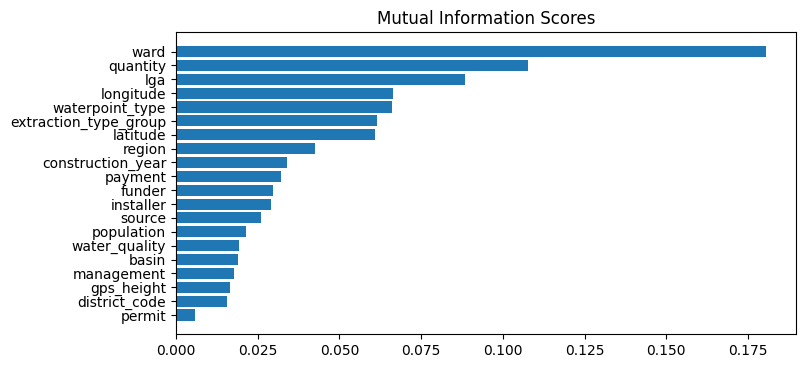

In [84]:
plot_mi_scores(mi_scores.head(20))

From the mutual information, `ward`, `quantity`, `funder` seems to have a strong relationship with the target (`status_group`) while features like `discrete_code`, `permit` have a weak relationship. However, we can't directly remove any feature just looking at the mutual information. 

#### **Binning**

In [85]:
def year_binning(df):
  df['construction_year'].replace(to_replace = (1960,1961,1962,1963,1964,1965,1966,1967,1968,1969), value ='60' , inplace=True)
  df['construction_year'].replace(to_replace = (1970,1971,1972,1973,1974,1975,1976,1977,1978,1979), value ='70s' , inplace=True)
  df['construction_year'].replace(to_replace = (1980,1981,1982,1983,1984,1985,1986,1987,1988,1989), value ='80s' , inplace=True)
  df['construction_year'].replace(to_replace = (1990,1991,1992,1993,1994,1995,1996,1997,1998,1999), value ='90s' , inplace=True)
  df['construction_year'].replace(to_replace = (2000,2001,2002,2003,2004,2005,2006,2007,2008,2009), value ='00s' , inplace=True)
  df['construction_year'].replace(to_replace = (2010,2011,2012,2013), value ='10s' , inplace=True)
  return df
X_train = year_binning(X_train)
X_test = year_binning(X_test)
X_train.construction_year.values

['90s', '10s', '00s', '80s', 0, ..., '90s', '90s', 0, 0, '00s']
Length: 59400
Categories (7, object): [0, '60', '70s', '80s', '90s', '00s', '10s']

In [86]:
# # plt.figure(1, figsize=(100,4))
# plt.figure(1, figsize=(100,20))
# train_data.loc[train_data['gps_height']!=0].gps_height.value_counts().plot(kind='bar')

In [87]:
# X_train.gps_height.value_counts().head(200)

In [88]:
# def population_binning(df):
#     X_new = df.copy()
#     cut_list = [0,1, 40,200,280,300,400, 1000,9000,31000]
#     X_new['gps_height'] = pd.cut(X_new['gps_height'], cut_list, labels=False)
#     X_new["gps_height"] = X_new["gps_height"].astype("category")
#     return X_new
# X_new = population_binning(X_train)
# X_new.head(5)

In [89]:
# Xy = pd.merge(y_train, X_new, how = 'inner', left_index = True, right_index=True)
# plt.figure(1, figsize=(20,4))
# sns.countplot(x='population', hue="status_group", data=Xy)

#### **Clustering**

In [90]:
def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    
    # Standardize
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    
    #Fit the KMeans model to X_scaled and create the cluster labels
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X["location_cluster"] = kmeans.fit_predict(X_scaled)
    X["location_cluster"] = X["location_cluster"].astype("category")
    
    return X, kmeans

def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

In [91]:
cluster_features = ["longitude", "latitude"]
all_data = pd.concat([X_train, X_test])
all_data_clustered, kmeans_model = cluster_labels(all_data.copy(), cluster_features, 10)
all_data_clustered.head(5)

X_train_clustered = all_data_clustered.loc[X_train.index, :] # train_data
X_test_clustered = all_data_clustered.loc[X_test.index, :] # test data
X_train_clustered.head(5)

,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,ward,population,public_meeting,permit,construction_year,extraction_type_group,management,payment,water_quality,quantity,source,waterpoint_type,location_cluster
id,,,,,,,,,,,,,,,,,,,,,,
69572,Others,1390,Others,34.938093,-9.856322,Lake Nyasa,Iringa,5,Ludewa,Mundindi,109,True,False,90s,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,3
8776,Others,1399,Others,34.698766,-2.147466,Lake Victoria,Mara,2,Serengeti,Natta,280,True,True,10s,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,6
34310,Others,686,world vision,37.460664,-3.821329,Pangani,Manyara,4,Simanjiro,Ngorika,250,True,True,00s,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,8
67743,Unicef,263,Others,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,Nanyumbu,58,True,True,80s,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,0
19728,Others,0,Others,31.130847,-1.825359,Lake Victoria,Kagera,1,Karagwe,Nyakasimbi,281,True,True,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,1


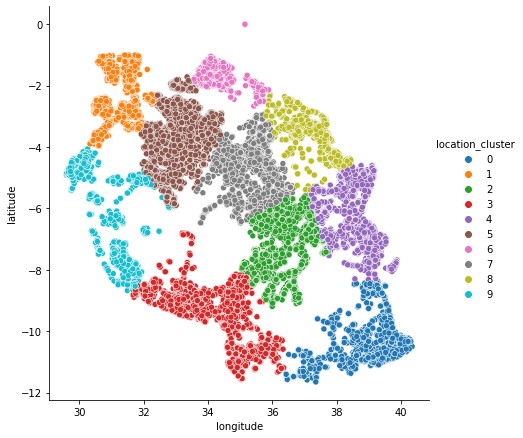

In [92]:
X_clustered = X_train_clustered.copy()

sns.relplot(
    x="longitude", y="latitude", hue="location_cluster", data=X_clustered, height=6,
);

In [93]:
X_clustered["location_cluster"] = X_clustered.location_cluster.astype("category")

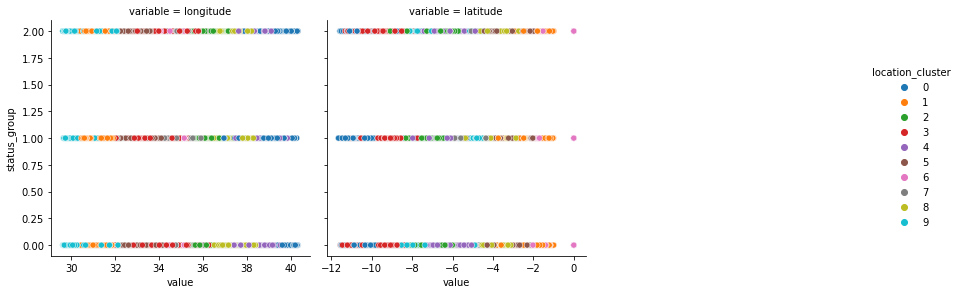

In [94]:
X_clustered["status_group"] = y_train
sns.relplot(
    x="value", y="status_group", hue="location_cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
    data=X_clustered.melt(
        value_vars=cluster_features, id_vars=["status_group", "location_cluster"],
    ),
);

In [95]:
X_train_clustered.drop(columns=["longitude", "latitude"], inplace=True)

#### **PCA - Principal Component Analysis**

In [96]:
all_data = pd.concat([X_train, X_test])

In [97]:
pca_features = [
        "gps_height",
        "population"
    ]

In [98]:
def getCorrelationsForFeatures(df, y):
    print("Correlation with Status Group:\n")
    print(df[pca_features].corrwith(y))
    return
getCorrelationsForFeatures(X_train.copy(), y_train.status_group)

Correlation with Status Group:

gps_height   -0.114029
population   -0.013527
dtype: float64


In [99]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [100]:
def getPcaFeatures(X):
    X_new = X.loc[:, pca_features]
    pca, X_pca, loadings = apply_pca(X_new)
    print(loadings, "\n")
    plot_variance(pca)
    return X_pca

                 PC1       PC2
gps_height -0.707107  0.707107
population  0.707107  0.707107 



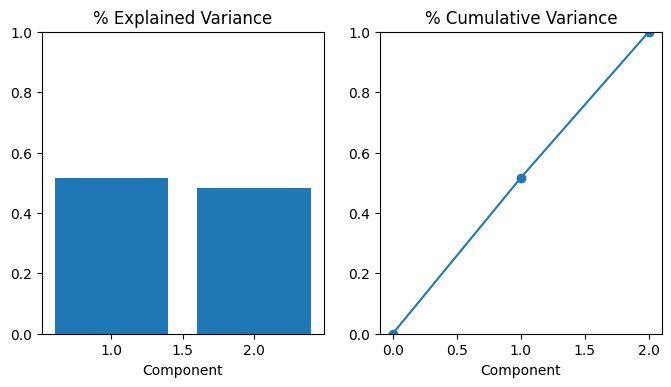

In [101]:
all_data_pca = getPcaFeatures(all_data)

In [102]:
X_train_pca = all_data_pca.loc[X_train.index, :] # train_data
X_test_pca = all_data_pca.loc[X_test.index, :] # test data

In [103]:
mi_scores = make_mi_scores(X_train_pca, y_train, discrete_features=False)
mi_scores

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


PC2    0.003502
PC1    0.001901
Name: MI Scores, dtype: float64

This graphs show that there is a strong relationship between `gps_height` & `population`. However, domainwise we cannot think about any relationship between these components. But when we consider the mutual information we can see a significant relationship between those components & the target (status_group). So we can use these components themselves as features.

In [104]:
def addPcaFeatures(X, X_pca):
    X_with_pca_features = X.copy()
    X_with_pca_features = X_with_pca_features.join(X_pca)
    return X_with_pca_features

In [105]:
all_data_pca_features = addPcaFeatures(all_data, all_data_pca)

In [106]:
X_train_pca_features = all_data_pca_features.loc[X_train.index, :]
X_test_pca_features = all_data_pca_features.loc[X_test.index, :]

In [107]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [108]:
encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
X_train_encoded = encoder.fit_transform(X_train, y_train, cols=["ward"])
X_test_encoded = encoder.transform(X_test)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [109]:
X_train_with_encoded = X_train
X_train_with_encoded["ward"] = X_train_encoded["ward_encoded"]
X_test_with_encoded = X_test
X_test_with_encoded["ward"] = X_test_encoded["ward_encoded"]

In [110]:
X_train_with_encoded.head(5)

,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,ward,population,public_meeting,permit,construction_year,extraction_type_group,management,payment,water_quality,quantity,source,waterpoint_type
id,,,,,,,,,,,,,,,,,,,,,
69572,Others,1390,Others,34.938093,-9.856322,Lake Nyasa,Iringa,5,Ludewa,0.794675,109,True,False,90s,gravity,vwc,pay annually,soft,enough,spring,communal standpipe
8776,Others,1399,Others,34.698766,-2.147466,Lake Victoria,Mara,2,Serengeti,0.724368,280,True,True,10s,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe
34310,Others,686,world vision,37.460664,-3.821329,Pangani,Manyara,4,Simanjiro,0.284024,250,True,True,00s,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple
67743,Unicef,263,Others,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,1.618343,58,True,True,80s,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple
19728,Others,0,Others,31.130847,-1.825359,Lake Victoria,Kagera,1,Karagwe,0.484024,281,True,True,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe


In [111]:
# # Encoding split
# X_copy = X.copy()
# X_copy["ward"] = X["ward"]
# X_copy["status_group"] = y["status_group"].copy()

# X_encode = X_copy.sample(frac=0.20, random_state=0)
# y_encode = X_encode.pop("status_group")

# # Training split
# X_pretrain = X_copy.drop(X_encode.index)
# y_train = X_pretrain.pop("status_group")

# # Choose a set of features to encode and a value for m
# encoder = MEstimateEncoder(cols=["ward"], m=0.5)

# # Fit the encoder on the encoding split
# encoder.fit(X_encode, y_encode)

# # Encode the training split
#    X_train = encoder.transform(X_pretrain, y_train)

#     encoder_feature = ["Ticket"]

#     plt.figure(dpi=90)
#     ax = sns.distplot(y_train, kde=True, hist=False)
#     ax = sns.distplot(X_train[encoder_feature], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
#     ax.set_xlabel("Survived");

## **Train & Test Model**

**Random Forest Classifier**

In [113]:
def RFClassifier():
    model = RandomForestClassifier(
        criterion='gini', 
        n_estimators=700,
        min_samples_split=10,
        min_samples_leaf=1,
        max_features='auto',
        oob_score=True,
        random_state=1,
        n_jobs=8,
        verbose=2,
        # weight="balanced"
    )
    return model

**XGBoost Classifier**

In [135]:
def XGBoostClassifier_v1():
    model = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx',
                        num_class = 3, maximize = False, eval_metric = 'merror', eta = .1,
                        max_depth = 10, colsample_bytree = .4, n_jobs = -1,learning_rate = 0.05, verbose=2)
    return model

def XGBoostClassifier_v2():
    model = XGBClassifier(nthread=2, num_class=3, 
                        min_child_weight=3, max_depth=15,
                        gamma=0.5, scale_pos_weight=0.8,
                        subsample=0.7, colsample_bytree = 0.8,
                        objective='multi:softmax')
    return model

**Train & Validate**

In [129]:
def score_dataset(X, y, model):
   
    for colname in X.select_dtypes(["category", "object"]):
        # X[colname], _ = X[colname].factorize() # Label encoding
        dummies = pd.get_dummies(X[colname], prefix=colname, drop_first=False) # One hot encoding
        X = X.join(dummies)
        X = X.drop(colname, 1)
    for colname in y.select_dtypes(["category", "object"]):
        # X[colname], _ = X[colname].factorize() # Label encoding
        dummies = pd.get_dummies(y[colname], prefix=colname, drop_first=False) # One hot encoding
        y = y.join(dummies)
        y = y.drop(colname, 1)
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    print(f"Train Accuracy: {accuracy_score(y_train, y_pred)}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test)}")

    print(f"Train Balanced Accuracy: {balanced_accuracy_score(y_train, y_pred)}")
    print(f"Test Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_test)}")

    return model

In [120]:
def oversample(X, y):
    oversampler = RandomOverSampler()
    X_over, y_over = oversampler.fit_sample(X, y)
    return X_over, y_over

In [125]:
def scale_columns(df):
    scaler = StandardScaler()
    for col in ["gps_height", "longitude", "latitude", "ward"]:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
    return df

In [126]:
# Scaled_X_train = X_train_with_encoded
# Scaled_X_train = scale_columns(X_train_with_encoded.copy())
# Scaled_X_test = X_test_with_encoded
# Scaled_X_test = scale_columns(X_test_with_encoded.copy())

In [136]:
model = score_dataset(X_train.copy(), y_train, XGBoostClassifier_v2())

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy: 0.8997474747474747
Test Accuracy: 0.8063131313131313
Train Balanced Accuracy: 0.7918901320732369
Test Balanced Accuracy: 0.6596246731541463


Initial Results:
*   Train Accuracy: 0.8977483164983165
*   Test Accuracy: 0.8144781144781145
*   Train Balanced Accuracy: 0.7727231204232443
*   Test Balanced Accuracy: 0.6637211894397568
--------------------------------------------------------------------------------
Results after considering Imbalanced Issue:
*   Train Accuracy: 0.8978535353535354
*   Test Accuracy: 0.7863636363636364
*   Train Balanced Accuracy: 0.9139070806996918
*   Test Balanced Accuracy: 0.7240594283267413
--------------------------------------------------------------------------------
Results after Location Clustering:
*   Train Accuracy: 0.8716119528619528
*   Test Accuracy: 0.7702020202020202
*   Train Balanced Accuracy: 0.8888252648357376
*   Test Balanced Accuracy: 0.7225629665406655
--------------------------------------------------------------------------------
Results after adding Principal Components:
*   Train Accuracy: 0.9090909090909091
*   Test Accuracy: 0.7878787878787878
*   Train Balanced Accuracy: 0.925159135696779
*   Test Balanced Accuracy: 0.7169532026105788
--------------------------------------------------------------------------------
Results after apply Target Encoding:
*   Train Accuracy: 0.9088804713804713
*   Test Accuracy: 0.7913299663299663
*   Train Balanced Accuracy: 0.9230028946792773
*   Test Balanced Accuracy: 0.7162858081643916
--------------------------------------------------------------------------------
Results after apply XGBoost:
*   Train Accuracy: 0.8383417508417509
*   Test Accuracy: 0.799074074074074
*   Train Balanced Accuracy: 0.6708432082781846
*   Test Balanced Accuracy: 0.6256999755388909
--------------------------------------------------------------------------------
Result after optimized XGBoost:
*   Train Accuracy: 0.9060395622895623
*   Test Accuracy: 0.8111111111111111
*   Train Balanced Accuracy: 0.8048584420622932
*   Test Balanced Accuracy: 0.6616543614288605




**Get Predictions**

In [132]:
def get_predictions(model, X):

    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        # X[colname], _ = X[colname].factorize() # Label encoding
        dummies = pd.get_dummies(X[colname], prefix=colname, drop_first=False) # One hot encoding
        X = X.join(dummies)
        X = X.drop(colname, 1)
    
    y_pred = model.predict(X)
    print(y_pred)

    data = {'id': X.index, 'status_group': y_pred}  
    submission = pd.DataFrame(data)
    target_status_group = {0:'functional',
                          1:'functional needs repair',
                          2:'non functional'} 
    submission['status_group'] = submission['status_group'].replace(target_status_group)
    submission.to_csv('submission5.csv')

    return

In [133]:
get_predictions(model, X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    2.5s


[2 0 2 ... 0 0 2]


[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    2.7s finished
